In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import random
import itertools
import math
import seaborn as sb
import pandas as pd
import os

Using DP for BlackJack more of a hassle.
* Probabilities must all be known for each state before DP can be applied. 
* Therefore, Monte Carlo is used

In [4]:
class cards:
    def __init__(self, num_deck=1000):
        assert num_deck > 0, "Must have at least 1 deck."
        # Initialize deck: large but finite deck (i.e. there is no infinite deck)
        self.num_deck = num_deck
        self.stock_cards()
        self.update_card_prob()
        
    def stock_cards(self):
        self.tot_cards = 500*52
        self.num_cards = {k:4*self.num_deck for k in list(range(1,10))+[11]}
        self.num_cards[10] = 4*self.num_deck*3
        
    def update_card_prob(self):
        self.card_probs = dict.fromkeys(self.num_cards.keys())
        for (k, v) in self.num_cards.items():
            self.card_probs[k] = v/self.tot_cards      
    def get_card(self):
        card = random.choices(list(self.card_probs.keys()), 
                              weights=self.card_probs.values(), k=1)[0]
        self.num_cards[card] -= 1; self.tot_cards -= 1
        if self.tot_cards == 0: 
            print("Out of cards! Restocking..."); self.stock_cards()
        self.update_card_prob()
        return card
    
    def starting_hand(self):
        return [self.get_card() for i in range(2)]
                
class player():  # The plaaaya
    '''Epsilon: Exploration factor
        Gamma: Discount factor for 1 step look forward'''
    def __init__(self, epsilon=0.05, gamma=0.2, debug=False):   # Epsilon Exploration factor
        self.debug = debug
        self.epsilon = epsilon
        self.gamma = gamma
        self.actions = ["Hit", "Pass"]
        ## States as follow: hand's sum (1-21) x Number of cards (<5 or >=5) x dealer's top card sum
        self.states = list(itertools.product(*[list(range(2, 22)), [">=5cards", "<5cards"], list(range(1,12))]))
        self.rewards =  {s: dict.fromkeys(self.actions, []) for s in self.states}
        self.values = {s: {k: 0 for k in self.actions} for s in self.states}
        self.policy = {s: {k:random.choice([0, 1]) for k in self.actions} for s in self.states}
        self.all_rewards = []
        self.game_states = []
    
    def player_decide(self, state):  # e-greedy adherance policy
        # choose available action by policy weights
        if self.debug: print("Player's Hand:",self.hand)
        if state[0] > 21: return False
        action = random.choices(list(self.policy[state].keys()), 
                                weights=list(self.policy[state].values()))[0]
        self.game_states.append((state, action))
        return action
    
    def learn(self, reward):
        ''' Core function that allows learner to learn from '''
        self.update_rewards(reward)
        self.update_values()
        self.update_policy()
        self.game_states = []   # finish episode
    
    def update_rewards(self, reward, gamma = 0.2):
        '''Save rewards to states occurred during the game:
        Method: 1 Step Forward
        gamma: discount factor '''
        reward_1step = [reward]
        if not len(self.game_states)>0: print("No game states"); return
        if self.debug: print(self.game_states)
        for n in range(len(self.game_states)-1):  # Loop for each step 
            state, action = self.game_states[n]
            next_state, _ = self.game_states[n+1]
            next_state_rewards = []
            [next_state_rewards+i for i in list(self.rewards[next_state].values())]
            reward_1step += map(lambda x:self.gamma*x, next_state_rewards)
            self.rewards[state][action] = self.rewards[state][action] + reward_1step
        # Last step
        if len(self.game_states)>0: 
            state, action = self.game_states[-1]
            self.rewards[state][action] = self.rewards[state][action] + [reward]
        if self.debug: print("Rewards:",self.rewards[self.game_states[0][0]])
        
    def update_values(self):
        for s, sa in self.rewards.items():
            for action, rewards in sa.items():  # Iterate state-action pairs
                ## Update with the mean of all rewards for this state-action pair
                if len(rewards) != 0: 
                    self.values[s][action] = np.mean(rewards)   ############ Mean/sum of reward
        if self.debug: print("Values:",self.values[self.game_states[0][0]])
        
    def update_policy(self):
        '''Update policy based on state-value pair'''
        def e_soft_policy_update(state, policy_SA):
            '''action_value: action-values Inner dictionary for each state'''
            action_values = self.values[state]
            # Determine optimal action by get max value action
            greedy_action = max(action_values, key=action_values.get)
            # Number of times the action has been taken
            A_taken_greedy = len(self.rewards[state][greedy_action])
            A_taken_nongreedy = len(np.array(list({k:v for k,v in self.rewards[state].items()
                                     if k!=greedy_action}.values())).ravel())
            for a in action_values.keys():  # loop over available actions
                if a == greedy_action:
                    policy_SA[a] = 1-self.epsilon+(self.epsilon/(A_taken_greedy+1))
                else: policy_SA[a] = self.epsilon/(A_taken_nongreedy+1)
                #print(policy_SA[a])
        ### Update Policy /state-action
        for s, a in self.policy.items():
            e_soft_policy_update(s,a)
        if self.debug: 
            print("Policy:",self.policy[self.game_states[0][0]])

class random_player(player):
    def __init__(self):
        super().__init__()
        
    def player_decide(self, state):
        if state[0] > 21: return False
        action = random.choices(list(self.policy[state].keys()))[0]
        self.rewards =  {s: dict.fromkeys(self.actions, []) for s in self.states}
        self.values = {s: {k: 0 for k in self.actions} for s in self.states}
        self.policy = {s: {k: np.random.choice([0,1])  for k in self.actions} for s in self.states}
        self.game_states.append((state, action))
        return action
    
class dealer():
    def __init__(self, min_sum=15):
        self.min_sum = min_sum
        
    def dealer_decide(self):   # Simplified Rule
        if sum(self.hand) <= self.min_sum: return True
        else: return False
        
class game():
    def __init__(self, cards, dealer, player):
        self.cards = cards()
        self.dealer = dealer
        self.player = player
        self.reward = {'win':1, 'lose':-1, 'push':0}
        print("Let's play a game of BlackJack!")
        print("*Game Initialized with",self.cards.num_deck,"decks.")
        print("Number of considered states",len(list(self.player.states)))
        
    def win_or_lose(self):  # Rule of the game
        dealer_handsum = sum(self.dealer.hand)
        player_handsum = sum(self.player.hand)
        print("Player:",player_handsum, "Dealer:",dealer_handsum)
        if player_handsum > 21:  # Player busted
            if dealer_handsum > 21: return self.reward['push']
            else: return self.reward['lose']
        else:   # Player not busted
            if player_handsum == 21 or len(self.player.hand) >= 5:  # Special ocassion (bj & charles 5)
                if dealer_handsum == 21: return self.reward['push']
                else: return self.reward['win']
            else:  
            # Normal rules
                # Bust
                if dealer_handsum > 21: return self.reward['win']
                else:
                # Under 21 compare
                    if player_handsum <= dealer_handsum: return self.reward['lose']
                    else: return self.reward['win']
        
        
    def get_game_state(self):
        if len(self.player.hand)>=5: charles5 = ">=5cards"
        else: charles5 = "<5cards"
        return (np.sum(self.player.hand), charles5, self.dealer.hand[1])
            
    def play_game(self):
        play = True
        self.player.hand = self.cards.starting_hand()
        self.dealer.hand = self.cards.starting_hand()
        self.play_1round()
        reward = self.win_or_lose()
        print("This round reward:", reward)
        self.player.all_rewards.append(reward)  # Save reward for record
        self.player.learn(reward)  # Learn and wipe state
        
    def play_1round(self):
        player_action = dealer_action = "Hit"
        while player_action=="Hit":
            player_action = self.player.player_decide(self.get_game_state())
            if player_action=="Hit": self.player.hand.append(self.cards.get_card())
        while dealer_action == "Hit":
            dealer_action = self.dealer.dealer_decide()
            if dealer_action=="Hit": self.dealer.hand.append(self.cards.get_card())
    
    def simulate_learning(self, n_rounds = 1000):
        self.n_rounds = n_rounds
        while n_rounds > 0:
            self.play_game()
            n_rounds -= 1
        pass


In [5]:
blackjack_one = game(cards, dealer(min_sum=15), player(epsilon=0.1, gamma=0.5, debug=True))
blackjack_one.play_game()

Let's play a game of BlackJack!
*Game Initialized with 1000 decks.
Number of considered states 440
Player's Hand: [8, 10]
Player's Hand: [8, 10, 3]
Player: 21 Dealer: 6
This round reward: 1
[((18, '<5cards', 3), 'Hit'), ((21, '<5cards', 3), 'Pass')]
Rewards: {'Hit': [1], 'Pass': []}
Values: {'Hit': 1.0, 'Pass': 0}
Policy: {'Hit': 0.9500000000000001, 'Pass': 0.1}


In [6]:
n_rounds = 20000
blackjack = game(cards, dealer(min_sum=15), player(epsilon=0.4, gamma=0.2, debug=False))
blackjack.simulate_learning(n_rounds = n_rounds)

Let's play a game of BlackJack!
*Game Initialized with 1000 decks.
Number of considered states 440
Player: 25 Dealer: 13
This round reward: -1
Player: 30 Dealer: 14
This round reward: -1
Player: 22 Dealer: 10
This round reward: -1
Player: 18 Dealer: 9
This round reward: 1
Player: 17 Dealer: 12
This round reward: 1
Player: 11 Dealer: 9
This round reward: 1
Player: 20 Dealer: 7
This round reward: 1
Player: 23 Dealer: 14
This round reward: -1
Player: 25 Dealer: 14
This round reward: -1
Player: 20 Dealer: 16
This round reward: 1
Player: 22 Dealer: 8
This round reward: -1
Player: 19 Dealer: 20
This round reward: -1
Player: 12 Dealer: 15
This round reward: -1
Player: 26 Dealer: 11
This round reward: -1
Player: 5 Dealer: 20
This round reward: -1
Player: 28 Dealer: 10
This round reward: -1
Player: 18 Dealer: 16
This round reward: 1
Player: 29 Dealer: 13
This round reward: -1
Player: 30 Dealer: 15
This round reward: -1
Player: 7 Dealer: 9
This round reward: -1
Player: 20 Dealer: 13
This round r

In [8]:
random_blackjack = game(cards, dealer(min_sum=15), random_player())
random_blackjack.simulate_learning(n_rounds = n_rounds)

Let's play a game of BlackJack!
*Game Initialized with 1000 decks.
Number of considered states 440
Player: 17 Dealer: 13
This round reward: 1
Player: 19 Dealer: 11
This round reward: 1
Player: 12 Dealer: 20
This round reward: -1
Player: 18 Dealer: 18
This round reward: -1
Player: 18 Dealer: 11
This round reward: 1
Player: 20 Dealer: 19
This round reward: 1
Player: 21 Dealer: 9
This round reward: 1
Player: 21 Dealer: 13
This round reward: 1
Player: 11 Dealer: 13
This round reward: -1
Player: 20 Dealer: 4
This round reward: 1
Player: 20 Dealer: 13
This round reward: 1
Player: 22 Dealer: 8
This round reward: -1
Player: 5 Dealer: 7
This round reward: -1
Player: 11 Dealer: 14
This round reward: -1
Player: 26 Dealer: 13
This round reward: -1
Player: 28 Dealer: 9
This round reward: -1
Player: 10 Dealer: 7
This round reward: 1
Player: 27 Dealer: 20
This round reward: -1
Player: 22 Dealer: 8
This round reward: -1
Player: 7 Dealer: 3
This round reward: 1
Player: 16 Dealer: 12
This round reward: 

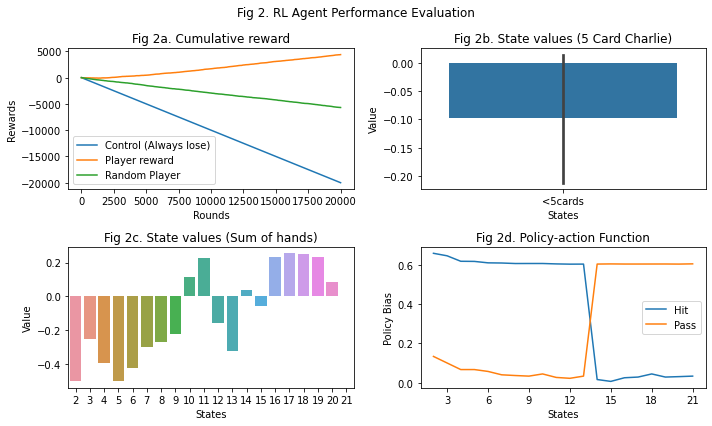

In [12]:
def plot_trained_policy(state_set_number=1, charles5=None, dealer_state=None):
    fig, ax = plt.subplots(2,2, figsize=(10, 6)); axes = ax.ravel()
    # Plot state-value function
    val_dict = {k:v for k,v in blackjack.player.values.items() if (k[1]==charles5 and k[2]==dealer_state)}
    pol_dict = {k:v for k,v in blackjack.player.policy.items() if (k[1]==charles5 and k[2]==dealer_state)}
    states = [state[state_set_number] for state in val_dict.keys()]
    states_5card = [state[1] for state in val_dict.keys()]
    mean_state_values = [np.array(list(av_dict.values())).ravel().mean() for av_dict in val_dict.values()]
    sb.barplot(x = states, y = mean_state_values, ax=axes[2])
    sb.barplot(x = states_5card, y = mean_state_values, ax=axes[1])
    # Plot policy action function
    policy_values = np.array([list(i.values()) for i in pol_dict.values()])
    action_policy_data = pd.DataFrame(np.hstack([np.array(states).reshape(-1,1), policy_values]),
                                      columns=["states"]+blackjack.player.actions)
    ap_agg_table = action_policy_data.groupby("states").agg('mean') #; print(ap_agg_table)
    
    axes[0].plot(range(n_rounds), np.arange(0, n_rounds*blackjack.reward['lose'], blackjack.reward['lose']), label='Control (Always lose)')
    axes[0].plot(np.cumsum(blackjack.player.all_rewards), label="Player reward")
    axes[0].plot(np.cumsum(random_blackjack.player.all_rewards), label='Random Player')
    axes[3].plot(ap_agg_table); plt.legend(blackjack.player.actions)
    axes[3].xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
    axes[0].legend()
    # 
    axes[0].set_title("Fig 2a. Cumulative reward"); axes[0].set_xlabel("Rounds"); axes[0].set_ylabel("Rewards")
    axes[1].set_title("Fig 2b. State values (5 Card Charlie)"); axes[1].set_xlabel("States"); axes[1].set_ylabel("Value")
    axes[2].set_title("Fig 2c. State values (Sum of hands)"); axes[2].set_xlabel("States"); axes[2].set_ylabel("Value")
    axes[3].set_title("Fig 2d. Policy-action Function"); axes[3].set_xlabel("States"); axes[3].set_ylabel("Policy Bias")
    plt.suptitle("Fig 2. RL Agent Performance Evaluation"); fig.tight_layout()
    return fig
        
fig = plot_trained_policy(0,"<5cards", 6); 
fig.savefig(os.getcwd()+r"/Trained_State-value_Policy_Plot3d(sum_of_hand)-condition-6+charles.png")

In [ ]:
class evaluate_agent(game, cards, dealer, player):
    def __init__(self):
        super().__init__(cards, dealer, player)        

In [ ]:
evaluate_agent()